Notes:
The linear regression model that worked the best was the 14th percentile with feature engineering v1. Next steps:
- Fit linear regression model with regulization and automatically remove those features.
- Add more feature engineering from v2 and monitor how it affects the model

In [123]:
#8.97
#11.69

In [323]:
# Import libraries needed for linear regression computation
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import log
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile
import scipy.stats as stats
import pylab 
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from operator import itemgetter
from sklearn.decomposition import PCA
%matplotlib inline

In [125]:
# LR Function

In [273]:
def run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id):
    # Build a model with all features to simply predict sales price
    train_X, validate_X, train_y, validate_y = train_test_split(
        train_data, train_saleprice, test_size=0.2, random_state=43344)

    model = sm.OLS(train_y, sm.add_constant(train_X)).fit()
    print('R2 is:', model.rsquared)
    
    # Let's get the train and test RMSE to compare
    train_predictions = model.predict(sm.add_constant(train_X))
    # print('The training RMSE is ', sqrt(mean_squared_error(train_y, train_predictions)), '!')
    avg_train_err = ((abs(train_y - train_predictions))/train_y)
    print('Training average percent error is', round(avg_train_err.mean()*100,2), '%.')


    validate_predictions = model.predict(sm.add_constant(validate_X))
    # print('The testing RMSE is ', sqrt(mean_squared_error(test_y, test_predictions)), '!')

    avg_test_err = ((abs(validate_y - validate_predictions))/validate_y)
    print('Validation average percent error is',round(avg_test_err.mean()*100,2), '%.')
    
    print('Difference is:', round(abs(avg_test_err.mean() - avg_train_err.mean())*100,2) )
    # Plot the residual plot along with the QQ-Plot
    
    # fitted values
    model_fitted = pd.DataFrame(model.fittedvalues)

    # model residuals
    model_residuals = pd.DataFrame(model.resid)

    # Residual plot
    residual_plot = plt.scatter(model_fitted , model_residuals)
    plt.show()

    #QQ-plot
    stats.probplot(model_residuals[0], dist='norm', plot=pylab)
    pylab.show()
    
    test_predictions = model.predict(sm.add_constant(test_data))
    test_predictions = pd.DataFrame(test_predictions)
    test_predictions.columns = ['SalePrice']
    test_predictions = pd.concat([test_id, test_predictions], axis=1)
    
    return test_predictions


def run_model_inputs_w_reg(train_data, train_id, train_saleprice, test_data, test_id, alpha_weight, lt_weight):
    
    # Build a model with all features to simply predict sales price
    train_X, validate_X, train_y, validate_y = train_test_split(
        train_data, train_saleprice, test_size=0.2, random_state=43344)

    model = sm.OLS(train_y, sm.add_constant(train_X)).fit_regularized(method='elastic_net', alpha=alpha_weight, L1_wt =lt_weight)
#     print('R2 is:', model.rsquared)
    
    # Let's get the train and test RMSE to compare
    train_predictions = model.predict(sm.add_constant(train_X))
    # print('The training RMSE is ', sqrt(mean_squared_error(train_y, train_predictions)), '!')
    avg_train_err = ((abs(train_y - train_predictions))/train_y)
    print('Training average percent error is', round(avg_train_err.mean()*100,2), '%.')


    validate_predictions = model.predict(sm.add_constant(validate_X))
    # print('The testing RMSE is ', sqrt(mean_squared_error(test_y, test_predictions)), '!')

    avg_test_err = ((abs(validate_y - validate_predictions))/validate_y)
    print('Validation average percent error is',round(avg_test_err.mean()*100,2), '%.')
    
    print('Difference is:', round(abs(avg_test_err.mean() - avg_train_err.mean())*100,2) )
    
    test_predictions = model.predict(sm.add_constant(test_data))
    test_predictions = pd.DataFrame(test_predictions)
    test_predictions.columns = ['SalePrice']
    test_predictions = pd.concat([test_id, test_predictions], axis=1)
    
    return test_predictions


# Feature Engineering Function V1

In [127]:
def feature_engineering_v1(model_data):
    # test_data has some nulls. Fill them with 0
    model_data['BsmtFullBath'] = model_data['BsmtFullBath'].fillna(0)
    model_data['BsmtHalfBath'] = model_data['BsmtHalfBath'].fillna(0)
    model_data['GarageCars'] = model_data['GarageCars'].fillna(0)
    
    # fill na with 0 in the GarageYrBuilt column
    model_data['GarageYrBlt'] = model_data['GarageYrBlt'].fillna(0.0)
    
    model_data['TotalLotArea'] = model_data['LotFrontage'].fillna(0) + model_data['LotArea']
    model_data = model_data.drop(columns=['LotFrontage', 'LotArea'])
    # This code is for living SF
    model_data['HaveBsmt'] = np.where(model_data['TotalBsmtSF'] == 0, 0,1)
    model_data['Have2ndFlr'] = np.where(model_data['2ndFlrSF'] == 0, 0,1)
    model_data['living_SF'] = (model_data['1stFlrSF'].fillna(0) + model_data['2ndFlrSF'].fillna(0) 
                               + model_data['TotalBsmtSF'].fillna(0))
    # Also dropping the lowqualitySF feature
    model_data = model_data.drop(columns=['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'LowQualFinSF'])
    
    # Make binary variables for the SF features
    model_data['MasVnrArea'] = model_data['MasVnrArea'].fillna(0)
    model_data['MasVnrAreaBin'] = np.where(model_data['MasVnrArea'] == 0, 0,1)
    model_data['WoodDeckSFBin'] = np.where(model_data['WoodDeckSF'] == 0, 0,1)
    model_data['HaveGarage'] = np.where(model_data['GarageArea'] == 0, 0,1)
    model_data['OpenPorchSFBin'] = np.where(model_data['OpenPorchSF'] == 0, 0,1)
    model_data['EnclosedPorchBin'] = np.where(model_data['EnclosedPorch'] == 0, 0,1)
    model_data['3SsnPorchBin'] = np.where(model_data['3SsnPorch'] == 0, 0,1)
    model_data['ScreenPorchBin'] = np.where(model_data['ScreenPorch'] == 0, 0,1)
    model_data['PoolAreaBin'] = np.where(model_data['PoolArea'] == 0, 0,1)
    
    # Sum up all the SF features as TotalSFfeatures
    model_data['TotalSFFeatures'] = (model_data['MasVnrArea'].fillna(0) + model_data['GarageArea'].fillna(0) 
                                     + model_data['WoodDeckSF'].fillna(0) + model_data['OpenPorchSF'].fillna(0) 
                                     + model_data['EnclosedPorch'].fillna(0) + model_data['3SsnPorch'].fillna(0) 
                                     + model_data['ScreenPorch'].fillna(0) + model_data['PoolArea'].fillna(0))
    
    # Drop the columns that you have applied EDA on
    model_data = model_data.drop(columns=['MasVnrArea','WoodDeckSF', 'GarageArea', 'OpenPorchSF', 
                                          'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea'])
    
    # Apply Feature Engineering on OverallCond and OverallQual columns
    model_data['OverallCondQual'] = (model_data['OverallCond'] * 1)+(model_data['OverallQual'])
    model_data = model_data.drop(columns = ['OverallCond', 'OverallQual'])
    
    # Add int variables for ExterQual and ExterCond
    model_data['ExterQualInt'] =  np.where(model_data['ExterQual'] == "Ex", 9, 
                                            np.where(model_data['ExterQual'] == "Gd", 7, 
                                                    np.where(model_data['ExterQual'] == "TA", 5, 
                                                            np.where(model_data['ExterQual'] == "Fa", 3, 
                                                                    np.where(model_data['ExterQual'] == "Po", 2,0)))))
    model_data['ExterCondInt'] =  np.where(model_data['ExterCond'] == "Ex", 9, 
                                             np.where(model_data['ExterCond'] == "Gd", 7, 
                                                    np.where(model_data['ExterCond'] == "TA", 5, 
                                                            np.where(model_data['ExterCond'] == "Fa", 3, 
                                                                    np.where(model_data['ExterCond'] == "Po", 2,0)))))
    model_data['ExterCondQual'] = (model_data['ExterCondInt']*1) + (model_data['ExterQualInt']*1)
    # Drop original ExterQual and ExterCond and keep int columns
    model_data = model_data.drop(columns=['ExterQual', 'ExterCond'])
    
    # Add int variables for all categorical basement variables
    model_data['BsmtQualInt'] =  np.where(model_data['BsmtQual'] == "Ex", 9, 
                                            np.where(model_data['BsmtQual'] == "Gd", 7, 
                                                    np.where(model_data['BsmtQual'] == "TA", 5, 
                                                            np.where(model_data['BsmtQual'] == "Fa", 3, 
                                                                    np.where(model_data['BsmtQual'] == "Po", 2,0)))))

    model_data['BsmtCondInt'] =  np.where(model_data['BsmtCond'] == "Ex", 9, 
                                            np.where(model_data['BsmtCond'] == "Gd", 7, 
                                                    np.where(model_data['BsmtCond'] == "TA", 5, 
                                                            np.where(model_data['BsmtCond'] == "Fa", 3, 
                                                                    np.where(model_data['BsmtCond'] == "Po", 2,0)))))

    model_data['BsmtExposureInt'] =  np.where(model_data['BsmtExposure'] == "Gd", 7, 
                                            np.where(model_data['BsmtExposure'] == "Av", 5, 
                                                    np.where(model_data['BsmtExposure'] == "Mn", 3, 
                                                            np.where(model_data['BsmtExposure'] == "No", 1, 0))))

    model_data['BsmtFinType1Int'] =  np.where(model_data['BsmtFinType1'] == "GLQ", 9, 
                                            np.where(model_data['BsmtFinType1'] == "ALQ", 7, 
                                                    np.where(model_data['BsmtFinType1'] == "BLQ", 5, 
                                                            np.where(model_data['BsmtFinType1'] == "Rec", 3, 
                                                                    np.where(model_data['BsmtFinType1'] == "LWQ", 1,
                                                                            np.where(model_data['BsmtFinType1'] == "Unf",1,0))))))

    model_data['BsmtFinType2Int'] =  np.where(model_data['BsmtFinType2'] == "GLQ", 9, 
                                            np.where(model_data['BsmtFinType2'] == "ALQ", 7, 
                                                    np.where(model_data['BsmtFinType2'] == "BLQ", 5, 
                                                            np.where(model_data['BsmtFinType2'] == "Rec", 3, 
                                                                    np.where(model_data['BsmtFinType2'] == "LWQ", 1,
                                                                            np.where(model_data['BsmtFinType2'] == "Unf",1,1))))))

    model_data = model_data.drop(columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'])
    
    model_data['BsmtQualCondExposureType'] = (model_data['BsmtFinType2Int'] + model_data['BsmtFinType1Int'] 
                                                + model_data['BsmtExposureInt'] + model_data['BsmtCondInt'] 
                                                + model_data['BsmtQualInt'])
    
    # Add intvariables for GarageQual and GarageCond
    model_data['GarageCondInt'] =  np.where(model_data['GarageCond'] == "Ex", 9, 
                                            np.where(model_data['GarageCond'] == "Gd", 7, 
                                                    np.where(model_data['GarageCond'] == "TA", 5, 
                                                            np.where(model_data['GarageCond'] == "Fa", 3, 
                                                                    np.where(model_data['GarageCond'] == "Po", 2,0)))))

    model_data['GarageQualInt'] =  np.where(model_data['GarageQual'] == "Ex", 9, 
                                            np.where(model_data['GarageQual'] == "Gd", 7, 
                                                    np.where(model_data['GarageQual'] == "TA", 5, 
                                                            np.where(model_data['GarageQual'] == "Fa", 3, 
                                                                    np.where(model_data['GarageQual'] == "Po", 2,0)))))

    model_data['GarageCondQual'] = (model_data['GarageCondInt'] + model_data['GarageQualInt'])

    model_data = model_data.drop(columns = ['GarageCond', 'GarageQual'])
    
    # Add interaction variables for KitchenQual
    model_data['KitchenQualInt'] =  np.where(model_data['KitchenQual'] == "Ex", 9, 
                                            np.where(model_data['KitchenQual'] == "Gd", 7, 
                                                    np.where(model_data['KitchenQual'] == "TA", 5, 
                                                            np.where(model_data['KitchenQual'] == "Fa", 3, 
                                                                    np.where(model_data['KitchenQual'] == "Po", 2,0)))))
    model_data = model_data.drop(columns = ['KitchenQual'])

    model_data['IsNotNormal'] = np.where(model_data['SaleCondition'] == "Normal", 0,1)
    model_data = model_data.drop(columns = ['SaleCondition'])

    model_data['IsRL'] = np.where(model_data['MSZoning'] == "RL", 1, 0)
    model_data = model_data.drop(columns = ["MSZoning"])

    model_data['IsWD'] = np.where(model_data['SaleType'] != 'WD', 1, 0)
    model_data = model_data.drop(columns = ['SaleType'])

    # Sum up all the qual and condition variables
    model_data['SumCondQualFea'] = (model_data['OverallCondQual'] + 
                                  model_data['ExterCondInt'] + model_data['ExterQualInt'] + 
                                  model_data['BsmtFinType2Int'] + model_data['BsmtFinType1Int'] +
                                  model_data['BsmtExposureInt'] + model_data['BsmtCondInt'] +
                                  model_data['BsmtQualInt'] + model_data['GarageCondInt'] +
                                  model_data['GarageQualInt'] + model_data['KitchenQualInt'])
    model_data['SumCondQualFea'] = (model_data['SumCondQualFea']**2)

    model_data['IsNotTyp'] = np.where(model_data['Functional'] != 'Typ', 1, 0)
    
    # Replace any null values in categorical variables with 'Not Available'
    for i in model_data.columns:
        if model_data[i].dtypes == 'object':
            model_data[i] = model_data[i].fillna('Not_Available')
    
    model_data = pd.get_dummies(model_data, drop_first=True)
    
    # Delete any Not_Available columns (no use in the model)
    model_data = model_data[model_data.columns.drop(list(model_data.filter(regex='Not_Available')))]
    
    id_col = model_data['Id']
    
    # Drop basementSF columns as it is taken care in the TotalSF Features and drop id columm
    model_data = model_data.drop(columns = ['Id', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'])
    # Drop month and year sold because that does not affect the variance of the house prices (see EDA)
    model_data = model_data.drop(columns=['MoSold', 'YrSold'])
    
    # Combine the bath columms and drop all the original bathroom columns
    model_data['num_bathroom'] = (model_data['BsmtFullBath'] + model_data['FullBath'] + 
                                  (model_data['BsmtHalfBath'] / 2) + (model_data['HalfBath'] / 2))
    
    model_data =  model_data.drop(columns=['BsmtFullBath', 'FullBath', 'HalfBath', 'BsmtHalfBath'])
    

    
    return model_data, id_col

In [215]:
def feature_engineering_v3(model_data):
    # test_data has some nulls. Fill them with 0
    model_data['BsmtFullBath'] = model_data['BsmtFullBath'].fillna(0)
    model_data['BsmtHalfBath'] = model_data['BsmtHalfBath'].fillna(0)
    model_data['GarageCars'] = model_data['GarageCars'].fillna(0)
    
    # fill na with 0 in the GarageYrBuilt column
    model_data['GarageYrBlt'] = model_data['GarageYrBlt'].fillna(0.0)
    
    model_data['TotalLotArea'] = model_data['LotFrontage'].fillna(0) + model_data['LotArea']
    model_data = model_data.drop(columns=['LotFrontage', 'LotArea'])
    # This code is for living SF
    model_data['HaveBsmt'] = np.where(model_data['TotalBsmtSF'] == 0, 0,1)
    model_data['Have2ndFlr'] = np.where(model_data['2ndFlrSF'] == 0, 0,1)
    model_data['living_SF'] = (model_data['1stFlrSF'].fillna(0) + model_data['2ndFlrSF'].fillna(0) 
                               + model_data['TotalBsmtSF'].fillna(0))
    # Also dropping the lowqualitySF feature
    model_data = model_data.drop(columns=['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'LowQualFinSF'])
    
    # Make binary variables for the SF features
    model_data['MasVnrArea'] = model_data['MasVnrArea'].fillna(0)
    model_data['MasVnrAreaBin'] = np.where(model_data['MasVnrArea'] == 0, 0,1)
    model_data['WoodDeckSFBin'] = np.where(model_data['WoodDeckSF'] == 0, 0,1)
    model_data['HaveGarage'] = np.where(model_data['GarageArea'] == 0, 0,1)
    model_data['OpenPorchSFBin'] = np.where(model_data['OpenPorchSF'] == 0, 0,1)
    model_data['EnclosedPorchBin'] = np.where(model_data['EnclosedPorch'] == 0, 0,1)
    model_data['3SsnPorchBin'] = np.where(model_data['3SsnPorch'] == 0, 0,1)
    model_data['ScreenPorchBin'] = np.where(model_data['ScreenPorch'] == 0, 0,1)
    model_data['PoolAreaBin'] = np.where(model_data['PoolArea'] == 0, 0,1)
    
    # Sum up all the SF features as TotalSFfeatures
    model_data['TotalSFFeatures'] = (model_data['MasVnrArea'].fillna(0) + model_data['GarageArea'].fillna(0) 
                                     + model_data['WoodDeckSF'].fillna(0) + model_data['OpenPorchSF'].fillna(0) 
                                     + model_data['EnclosedPorch'].fillna(0) + model_data['3SsnPorch'].fillna(0) 
                                     + model_data['ScreenPorch'].fillna(0) + model_data['PoolArea'].fillna(0))
    
    # Drop the columns that you have applied EDA on
    model_data = model_data.drop(columns=['MasVnrArea','WoodDeckSF', 'GarageArea', 'OpenPorchSF', 
                                          'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea'])
    
    # Apply Feature Engineering on OverallCond and OverallQual columns
    model_data['OverallCondQual'] = (model_data['OverallCond'] * 1)+(model_data['OverallQual'])
    model_data = model_data.drop(columns = ['OverallCond', 'OverallQual'])
    
    # Add int variables for ExterQual and ExterCond
    model_data['ExterQualInt'] =  np.where(model_data['ExterQual'] == "Ex", 9, 
                                            np.where(model_data['ExterQual'] == "Gd", 7, 
                                                    np.where(model_data['ExterQual'] == "TA", 5, 
                                                            np.where(model_data['ExterQual'] == "Fa", 3, 
                                                                    np.where(model_data['ExterQual'] == "Po", 2,0)))))
    model_data['ExterCondInt'] =  np.where(model_data['ExterCond'] == "Ex", 9, 
                                             np.where(model_data['ExterCond'] == "Gd", 7, 
                                                    np.where(model_data['ExterCond'] == "TA", 5, 
                                                            np.where(model_data['ExterCond'] == "Fa", 3, 
                                                                    np.where(model_data['ExterCond'] == "Po", 2,0)))))
    model_data['ExterCondQual'] = (model_data['ExterCondInt']*1) + (model_data['ExterQualInt']*1)
    # Drop original ExterQual and ExterCond and keep int columns
    model_data = model_data.drop(columns=['ExterQual', 'ExterCond'])
    
    # Add int variables for all categorical basement variables
    model_data['BsmtQualInt'] =  np.where(model_data['BsmtQual'] == "Ex", 9, 
                                            np.where(model_data['BsmtQual'] == "Gd", 7, 
                                                    np.where(model_data['BsmtQual'] == "TA", 5, 
                                                            np.where(model_data['BsmtQual'] == "Fa", 3, 
                                                                    np.where(model_data['BsmtQual'] == "Po", 2,0)))))

    model_data['BsmtCondInt'] =  np.where(model_data['BsmtCond'] == "Ex", 9, 
                                            np.where(model_data['BsmtCond'] == "Gd", 7, 
                                                    np.where(model_data['BsmtCond'] == "TA", 5, 
                                                            np.where(model_data['BsmtCond'] == "Fa", 3, 
                                                                    np.where(model_data['BsmtCond'] == "Po", 2,0)))))

    model_data['BsmtExposureInt'] =  np.where(model_data['BsmtExposure'] == "Gd", 7, 
                                            np.where(model_data['BsmtExposure'] == "Av", 5, 
                                                    np.where(model_data['BsmtExposure'] == "Mn", 3, 
                                                            np.where(model_data['BsmtExposure'] == "No", 1, 0))))

    model_data['BsmtFinType1Int'] =  np.where(model_data['BsmtFinType1'] == "GLQ", 9, 
                                            np.where(model_data['BsmtFinType1'] == "ALQ", 7, 
                                                    np.where(model_data['BsmtFinType1'] == "BLQ", 5, 
                                                            np.where(model_data['BsmtFinType1'] == "Rec", 3, 
                                                                    np.where(model_data['BsmtFinType1'] == "LWQ", 1,
                                                                            np.where(model_data['BsmtFinType1'] == "Unf",1,0))))))

    model_data['BsmtFinType2Int'] =  np.where(model_data['BsmtFinType2'] == "GLQ", 9, 
                                            np.where(model_data['BsmtFinType2'] == "ALQ", 7, 
                                                    np.where(model_data['BsmtFinType2'] == "BLQ", 5, 
                                                            np.where(model_data['BsmtFinType2'] == "Rec", 3, 
                                                                    np.where(model_data['BsmtFinType2'] == "LWQ", 1,
                                                                            np.where(model_data['BsmtFinType2'] == "Unf",1,1))))))

    model_data = model_data.drop(columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'])
    
    model_data['BsmtQualCondExposureType'] = (model_data['BsmtFinType2Int'] + model_data['BsmtFinType1Int'] 
                                                + model_data['BsmtExposureInt'] + model_data['BsmtCondInt'] 
                                                + model_data['BsmtQualInt'])
    
    # Add intvariables for GarageQual and GarageCond
    model_data['GarageCondInt'] =  np.where(model_data['GarageCond'] == "Ex", 9, 
                                            np.where(model_data['GarageCond'] == "Gd", 7, 
                                                    np.where(model_data['GarageCond'] == "TA", 5, 
                                                            np.where(model_data['GarageCond'] == "Fa", 3, 
                                                                    np.where(model_data['GarageCond'] == "Po", 2,0)))))

    model_data['GarageQualInt'] =  np.where(model_data['GarageQual'] == "Ex", 9, 
                                            np.where(model_data['GarageQual'] == "Gd", 7, 
                                                    np.where(model_data['GarageQual'] == "TA", 5, 
                                                            np.where(model_data['GarageQual'] == "Fa", 3, 
                                                                    np.where(model_data['GarageQual'] == "Po", 2,0)))))

    model_data['GarageCondQual'] = (model_data['GarageCondInt'] + model_data['GarageQualInt'])

    model_data = model_data.drop(columns = ['GarageCond', 'GarageQual'])
    
    # Add interaction variables for KitchenQual
    model_data['KitchenQualInt'] =  np.where(model_data['KitchenQual'] == "Ex", 9, 
                                            np.where(model_data['KitchenQual'] == "Gd", 7, 
                                                    np.where(model_data['KitchenQual'] == "TA", 5, 
                                                            np.where(model_data['KitchenQual'] == "Fa", 3, 
                                                                    np.where(model_data['KitchenQual'] == "Po", 2,0)))))
    model_data = model_data.drop(columns = ['KitchenQual'])

    model_data['IsNotNormal'] = np.where(model_data['SaleCondition'] == "Normal", 0,1)
    model_data = model_data.drop(columns = ['SaleCondition'])

    model_data['IsRL'] = np.where(model_data['MSZoning'] == "RL", 1, 0)
    model_data = model_data.drop(columns = ["MSZoning"])

    model_data['IsWD'] = np.where(model_data['SaleType'] != 'WD', 1, 0)
    model_data = model_data.drop(columns = ['SaleType'])

    # Sum up all the qual and condition variables
    model_data['SumCondQualFea'] = (model_data['OverallCondQual'] + 
                                  model_data['ExterCondInt'] + model_data['ExterQualInt'] + 
                                  model_data['BsmtFinType2Int'] + model_data['BsmtFinType1Int'] +
                                  model_data['BsmtExposureInt'] + model_data['BsmtCondInt'] +
                                  model_data['BsmtQualInt'] + model_data['GarageCondInt'] +
                                  model_data['GarageQualInt'] + model_data['KitchenQualInt'])
    model_data['SumCondQualFea'] = (model_data['SumCondQualFea']**2)

    model_data['IsNotTyp'] = np.where(model_data['Functional'] != 'Typ', 1, 0)
    
    # Replace any null values in categorical variables with 'Not Available'
    for i in model_data.columns:
        if model_data[i].dtypes == 'object':
            model_data[i] = model_data[i].fillna('Not_Available')
    
    model_data = pd.get_dummies(model_data, drop_first=True)
    
    # Delete any Not_Available columns (no use in the model)
    model_data = model_data[model_data.columns.drop(list(model_data.filter(regex='Not_Available')))]
    
    id_col = model_data['Id']
    
    # Drop basementSF columns as it is taken care in the TotalSF Features and drop id columm
    model_data = model_data.drop(columns = ['Id', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'])
    # Drop month and year sold because that does not affect the variance of the house prices (see EDA)
    model_data = model_data.drop(columns=['MoSold', 'YrSold'])
    
    # Combine the bath columms and drop all the original bathroom columns
    model_data['num_bathroom'] = (model_data['BsmtFullBath'] + model_data['FullBath'] + 
                                  (model_data['BsmtHalfBath'] / 2) + (model_data['HalfBath'] / 2))
    
    model_data =  model_data.drop(columns=['BsmtFullBath', 'FullBath', 'HalfBath', 'BsmtHalfBath'])
    
    model_data = model_data.drop(columns = ['Alley_Pave', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Condition1_PosN',
                           'Condition1_RRAn', 'BldgType_Duplex', 'RoofMatl_WdShake', 'Exterior1st_AsphShn',
                          'Exterior2nd_Brk Cmn', 'Exterior2nd_CBlock', 'Foundation_Wood', 'Functional_Sev',
                          'GarageType_CarPort', 'Fence_GdWo', 'Fence_MnWw', 'MiscFeature_Othr'])
    
    model_data = model_data.drop(columns=['BsmtExposureInt','BsmtFinType1Int', 'BsmtFinType2Int', 'BsmtQualInt', 
                                          'BsmtCondInt'])
    
    model_data = model_data.drop(columns = ['LotShape_Reg', 'HouseStyle_SFoyer', 'Exterior1st_BrkComm',
                                        'Exterior1st_VinylSd', 'Exterior2nd_AsphShn', 'Exterior2nd_CmentBd', 
                                        'Exterior2nd_Wd Shng', 'Heating_Grav', 'PavedDrive_P'])
    
    model_data = model_data.drop(columns=['MasVnrAreaBin', '3SsnPorchBin', 'LotShape_IR2', 'Neighborhood_MeadowV', 
                                      'Condition1_PosA', 'Condition1_RRNn'])
    
    model_data = model_data.drop(columns = ['WoodDeckSFBin', 'LotConfig_FR3', 'Neighborhood_BrkSide',
                                        'Neighborhood_NPkVill', 'Electrical_FuseP', 'PoolQC_Gd'])
    
    model_data = model_data.drop(columns = ['Exterior2nd_BrkFace', 'Functional_Mod', 'GarageType_Attchd'])
    
    model_data = model_data.drop(columns = ['HaveBsmt', 'HaveGarage', 'ScreenPorchBin', 'PoolAreaBin', 
                                        'LotShape_IR3', 'Neighborhood_Timber', 'Condition1_Norm', 
                                        'Condition1_RRNe', 'Condition2_PosA', 'Condition2_PosN', 'BldgType_2fmCon', 
                                       'HouseStyle_1.5Unf', 'HouseStyle_2Story', 'Exterior2nd_Stone', 'Foundation_Slab'
                                       , 'Heating_Wall'])
    model_data = model_data.drop(columns = ['Have2ndFlr', 'IsRL', 'LandContour_Low', 'LandSlope_Sev', 'BldgType_Twnhs',
                                       'HouseStyle_1Story', 'RoofStyle_Shed', 'Electrical_FuseF'])
    
    model_data = model_data.drop(columns = ['ExterCondInt', 'IsNotNormal', 'Exterior1st_CBlock', 'Exterior1st_Stucco',
                                        'HeatingQC_Fa', 'HeatingQC_Po', 'Functional_Typ'])
    
    return model_data, id_col

# LR Model with regulization

In [216]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v1(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v1(test_data)
train_data = train_data[list(test_data.columns)]
print(train_data.shape)
print(test_data.shape)

(1460, 182)
(1459, 182)


R2 is: 0.9200599181329416
Training average percent error is 8.97 %.
Validation average percent error is 11.68 %.
Difference is: 2.71


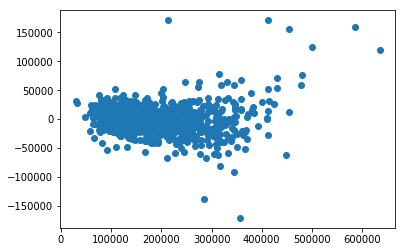

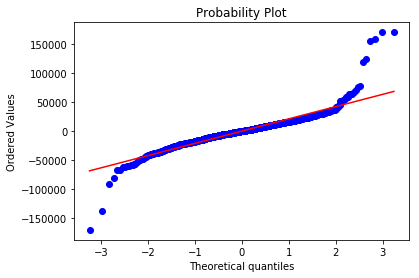

In [217]:
test_predictions = run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id)

In [131]:
# Build a model with all features to simply predict sales price
train_X, validate_X, train_y, validate_y = train_test_split(
    train_data, train_saleprice, test_size=0.2, random_state=43344)

model = sm.OLS(train_y, sm.add_constant(train_X)).fit_regularized(method='elastic_net', alpha=0.5, L1_wt =1)
print('Taking out:', model.params[model.params == 0].shape[0]/model.params.shape[0])
print(model.params[model.params == 0])

Taking out: 0.09836065573770492
Alley_Pave              0.0
Neighborhood_Blueste    0.0
Neighborhood_BrDale     0.0
Condition1_PosN         0.0
Condition1_RRAn         0.0
BldgType_Duplex         0.0
RoofMatl_WdShake        0.0
Exterior1st_AsphShn     0.0
Exterior1st_BrkComm     0.0
Exterior2nd_AsphShn     0.0
Exterior2nd_Brk Cmn     0.0
Exterior2nd_CBlock      0.0
Foundation_Wood         0.0
Functional_Sev          0.0
GarageType_CarPort      0.0
Fence_GdWo              0.0
Fence_MnWw              0.0
MiscFeature_Othr        0.0
dtype: float64


In [132]:
train_data = train_data.drop(columns = ['Alley_Pave', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Condition1_PosN',
                           'Condition1_RRAn', 'BldgType_Duplex', 'RoofMatl_WdShake', 'Exterior1st_AsphShn',
                          'Exterior2nd_Brk Cmn', 'Exterior2nd_CBlock', 'Foundation_Wood', 'Functional_Sev',
                          'GarageType_CarPort', 'Fence_GdWo', 'Fence_MnWw', 'MiscFeature_Othr'])
test_data = test_data.drop(columns = ['Alley_Pave', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Condition1_PosN',
                           'Condition1_RRAn', 'BldgType_Duplex', 'RoofMatl_WdShake', 'Exterior1st_AsphShn',
                          'Exterior2nd_Brk Cmn', 'Exterior2nd_CBlock', 'Foundation_Wood', 'Functional_Sev',
                          'GarageType_CarPort', 'Fence_GdWo', 'Fence_MnWw', 'MiscFeature_Othr'])

print(train_data.shape)
print(test_data.shape)

(1460, 166)
(1459, 166)


R2 is: 0.9189940178222984
Training average percent error is 9.09 %.
Validation average percent error is 11.5 %.
Difference is: 2.42


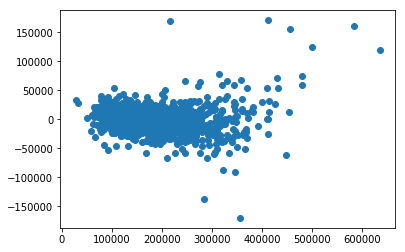

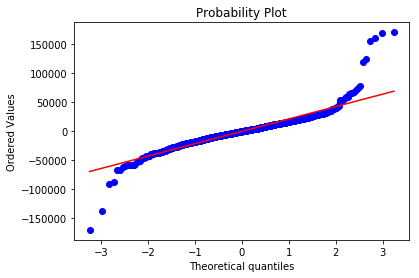

In [133]:
test_predictions = run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id)

#### Model is doing a lot better after taking out terms with params 0 from regulization. Updating the feature_eng_v3 by dropping these columns

#### Applied regulization again and found out the following columns have params of zero (alpha value: 1)
(columns = ['LotShape_Reg', 'HouseStyle_SFoyer', 'Exterior1st_BrkComm',
                                        'Exterior1st_VinylSd', 'Exterior2nd_AsphShn', 'Exterior2nd_CmentBd', 
                                        'Exterior2nd_Wd Shng', 'Heating_Grav', 'PavedDrive_P'])

# LR with feature eng V3

In [176]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]
print(train_data.shape)
print(test_data.shape)

(1460, 146)
(1459, 146)


#### Dropping the basement int features improves the model so I will add it to feature eng v3

R2 is: 0.9172832650510253
Training average percent error is 9.18 %.
Validation average percent error is 11.22 %.
Difference is: 2.04


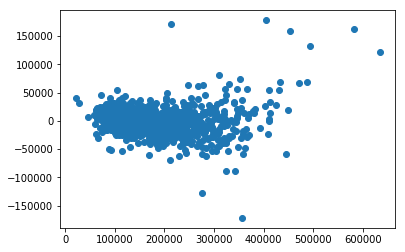

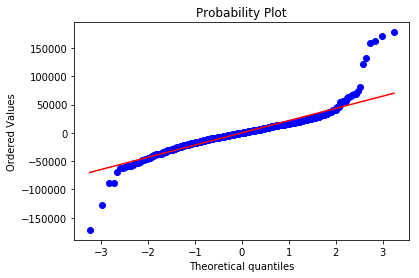

In [138]:
test_predictions = run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id)
# Export submit csv (Score: 0.16778)
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# test_predictions.to_csv(submit_filepath + 'fea_eng_v3.csv', index=False, header=True)

### Applied regulization again and took out the following columns:

columns=['MasVnrAreaBin', '3SsnPorchBin', 'LotShape_IR2', 'Neighborhood_MeadowV', 
                                      'Condition1_PosA', 'Condition1_RRNn']
                                      
columns = ['WoodDeckSFBin', 'LotConfig_FR3', 'Neighborhood_BrkSide',
                                         'Neighborhood_NPkVill', 'Electrical_FuseP', 'PoolQC_Gd']
                                         
columns = ['Exterior2nd_BrkFace', 'Functional_Mod', 'GarageType_Attchd'])

columns = ['HaveBsmt', 'HaveGarage', 'ScreenPorchBin', 'PoolAreaBin', 
                                        'LotShape_IR3', 'Neighborhood_Timber', 'Condition1_Norm', 
                                        'Condition1_RRNe', 'Condition2_PosA', 'Condition2_PosN', 'BldgType_2fmCon', 
                                       'HouseStyle_1.5Unf', 'HouseStyle_2Story', 'Exterior2nd_Stone','Foundation_Slab', 'Heating_Wall'])
                                       
                                       
[v5] columns = ['Have2ndFlr', 'IsRL', 'LandContour_Low', 'LandSlope_Sev', 'BldgType_Twnhs',
                                       'HouseStyle_1Story', 'RoofStyle_Shed', 'Electrical_FuseF'])

[v6] columns = ['ExterCondInt', 'IsNotNormal', 'Exterior1st_CBlock', 'Exterior1st_Stucco',
                                        'HeatingQC_Fa', 'HeatingQC_Po', 'Functional_Typ'])

In [261]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]
print(train_data.shape)
print(test_data.shape)

(1460, 113)
(1459, 113)


R2 is: 0.9040232309596496
Training average percent error is 9.7 %.
Validation average percent error is 10.94 %.
Difference is: 1.24


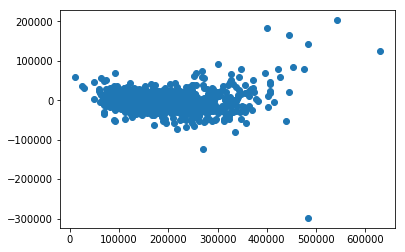

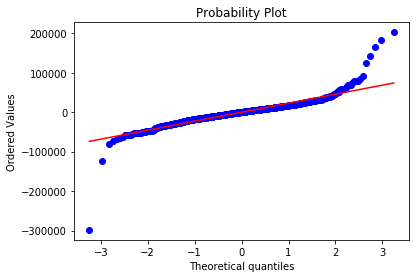

In [262]:
test_predictions = run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id)
# Export submit csv (Score: 0.16656 [v1], 0.16458 [v2], 0.16661 [v3], 0.15725 [v4], 0.15701 [v5], 0.16022 [v6])
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# test_predictions.to_csv(submit_filepath + 'fea_eng_v3_v5.csv', index=False, header=True)

In [ ]:
# Applying PCA to Non-Normalized Data

In [326]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]
print(train_data.shape)
print(test_data.shape)

(1460, 113)
(1459, 113)


No. of Features: 14
R2 is: 0.8521594436339188
Training average percent error is 11.6 %.
Validation average percent error is 12.87 %.
Difference is: 1.28


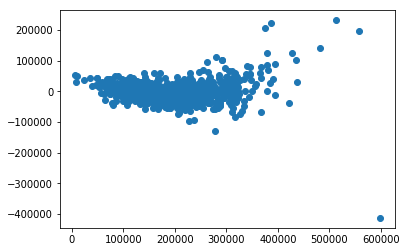

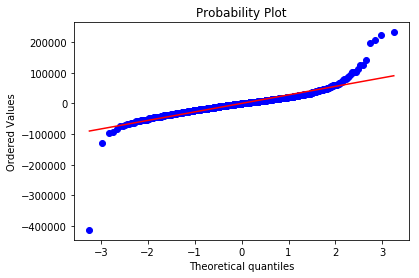

In [352]:
pca = PCA(n_components=round(train_data.shape[1]/8))
train_components = pca.fit_transform(train_data)
train_pca = pd.DataFrame(data = train_components)

test_components = pca.fit_transform(train_data)
test_pca = pd.DataFrame(data = test_components)

print('No. of Features:', train_pca.shape[1])

test_prediction = run_model_inputs(train_components, train_id, train_saleprice, test_components, test_id)
# Export submit csv ()
submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
test_predictions.to_csv(submit_filepath + 'fea_eng_v3_pca_' + str(train_pca.shape[1]) + '.csv', index=False, header=True)

In [224]:
for i in train_data.columns:
    print(i)

MSSubClass
YearBuilt
YearRemodAdd
GrLivArea
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
MiscVal
TotalLotArea
living_SF
OpenPorchSFBin
EnclosedPorchBin
TotalSFFeatures
OverallCondQual
ExterQualInt
ExterCondInt
ExterCondQual
BsmtQualCondExposureType
GarageCondInt
GarageQualInt
GarageCondQual
KitchenQualInt
IsNotNormal
IsWD
SumCondQualFea
IsNotTyp
Street_Pave
LandContour_HLS
LandContour_Lvl
LotConfig_CulDSac
LotConfig_FR2
LotConfig_Inside
LandSlope_Mod
Neighborhood_ClearCr
Neighborhood_CollgCr
Neighborhood_Crawfor
Neighborhood_Edwards
Neighborhood_Gilbert
Neighborhood_IDOTRR
Neighborhood_Mitchel
Neighborhood_NAmes
Neighborhood_NWAmes
Neighborhood_NoRidge
Neighborhood_NridgHt
Neighborhood_OldTown
Neighborhood_SWISU
Neighborhood_Sawyer
Neighborhood_SawyerW
Neighborhood_Somerst
Neighborhood_StoneBr
Neighborhood_Veenker
Condition1_Feedr
Condition1_RRAe
Condition2_Feedr
Condition2_Norm
BldgType_TwnhsE
HouseStyle_2.5Unf
HouseStyle_SLvl
RoofStyle_Gable
RoofStyle_Gamb